In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from typing import Callable
import SimpleITK as sitk
from torch.utils.data import DataLoader, Dataset
from os.path import abspath
from pathlib import Path
from monai import transforms as mt
import matplotlib.pyplot as plt
from monai.data import CacheDataset
from sklearn.model_selection import train_test_split

c:\Users\samar\Desktop\Samar\Studies\MSc\BiBC\AIMI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\samar\Desktop\Samar\Studies\MSc\BiBC\AIMI\venv\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


## Data Loading

In [3]:
def collect_samples(root: Path, is_test: bool = False) -> list[dict[str, Path]]:
    """
    Collects the samples from the WMH dataset.

    Parameters
    ----------
    root : Path
        The root directory of the dataset.
    is_test : bool
        Whether to collect the test set or the training set.

    Returns
    -------
    list[dict[str, Path]]
        A list of dictionaries containing the image and label paths.
    """
  
    samples = []
    # Iterate through each subject directory
    for subject_dir in root.iterdir():
        if subject_dir.is_dir():  # Check if it's a directory
            flair_path = subject_dir / "FLAIR.nii.gz"
            t1_path = subject_dir / "T1.nii.gz"
            WMH_path = subject_dir / "wmh.nii.gz"
            
            # Check if all required files exist
            if flair_path.exists() and t1_path.exists() and WMH_path.exists():
                sample = {
                    "flair": flair_path,
                    "t1": t1_path,
                    "WMH": WMH_path
                }
                samples.append(sample)
            else:
                print(f"Missing files in {subject_dir}: "
                      f"{'FLAIR' if not flair_path.exists() else ''} "
                      f"{'T1' if not t1_path.exists() else ''} "
                      f"{'wmh' if not WMH_path.exists() else ''}")

    return samples

In [4]:
# Note from lars: I've changed the keys from [image, label] to the keynames our dataset uses
# Source: https://docs.monai.io/en/stable/transforms.html#maptransform
# However for the rest i'm unfamilier with what this code does exactly
# For instance does it make sence to apply some transforms to to our input but not our labels?
# TODO - *Eva* can you see if you can understand this? since it's data augmentation i think.

train_transforms = mt.Compose([
    mt.LoadImaged(keys=["flair", "t1", "WMH"]),
    mt.EnsureChannelFirstd(keys=["flair", "t1", "WMH"]),
    mt.NormalizeIntensityd(keys=["flair", "t1"])
    # You can add more transforms here! See
    # https://docs.monai.io/en/stable/transforms.html#dictionary-transforms
])

val_transforms = mt.Compose([
    mt.LoadImaged(keys=["flair", "t1", "WMH"]),
    mt.EnsureChannelFirstd(keys=["flair", "t1", "WMH"]),
    mt.NormalizeIntensityd(keys=["flair", "t1"])
])


# Actually running loading 
# TODO - *Bas, Eva, Ishar* Create a data folder and put the wmh data there in accordance with this path
root = Path(abspath(""))
wmh_path = root.joinpath("data/WMH")
sample_paths = [item for item in wmh_path.iterdir() if item.is_dir()]
samples = []

for sample_path in sample_paths:
    samples.extend(collect_samples(sample_path))

# You might get an error here, make sure you install the required extra dependencies
# https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

train_samples, temp_samples = train_test_split(samples, train_size=0.8, random_state=42, shuffle=True)
val_samples, test_samples = train_test_split(temp_samples, test_size=0.5, random_state=42, shuffle=True)

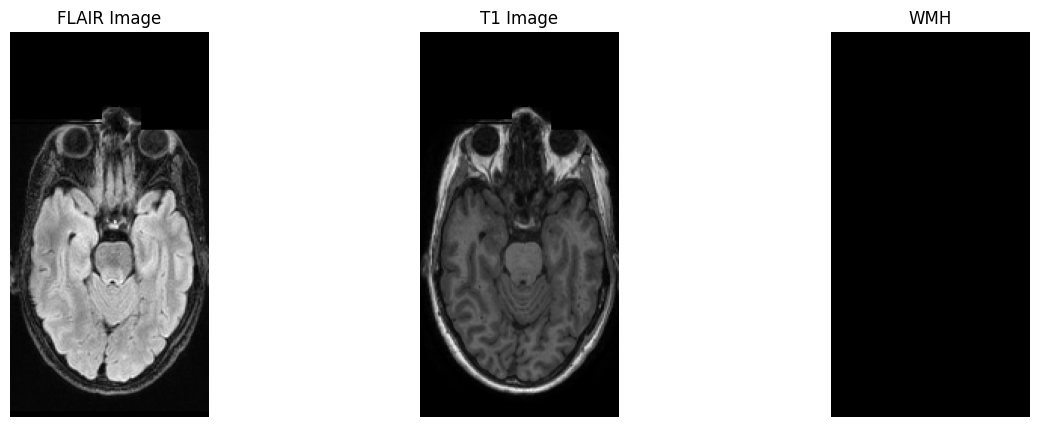

60

In [5]:
def load_nifti_image(image_path: Path):
    """Load a NIfTI image using SimpleITK."""
    image = sitk.ReadImage(str(image_path))
    return sitk.GetArrayFromImage(image)  # Convert to NumPy array

def visualize_sample(sample):
    """Visualize FLAIR, T1, and WMH images from a sample."""
    flair_image = load_nifti_image(sample['flair'])
    t1_image = load_nifti_image(sample['t1'])
    label_image = load_nifti_image(sample['WMH'])

    # Select a slice to visualize (e.g., the middle slice)
    slice_index = flair_image.shape[0] // 2

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # FLAIR Image
    axes[0].imshow(flair_image[slice_index, :, :], cmap='gray')
    axes[0].set_title('FLAIR Image')
    axes[0].axis('off')

    # T1 Image
    axes[1].imshow(t1_image[slice_index, :, :], cmap='gray')
    axes[1].set_title('T1 Image')
    axes[1].axis('off')

    # WMH Label
    axes[2].imshow(label_image[slice_index, :, :], cmap='gray')
    axes[2].set_title('WMH')
    axes[2].axis('off')

    plt.show()

# Example usage
# root = Path(r"./WMH/WMH/Amsterdam").resolve()
# root2 = Path(r"./WMH/WMH/Singapore").resolve()
# root3 = Path(r"./WMH/WMH/Utrecht").resolve()
# samples = collect_samples(root) + collect_samples(root2) + collect_samples(root3)

# Visualize the first sample if available
if samples:
    visualize_sample(samples[0])  # Visualize the first sample
else:
    print("No samples found to visualize.")
len(samples)

## Model setup

In [6]:
# Class holding the double convolution
class DoubleConv(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        use_norm: bool = True,
    ) -> None:
        super().__init__()
        
        # For now we are just considering 2d input
        # Thus expected input dimensions is [batch_size, channels, height, width] 
        # Or when not using batches [channels, height, width]
        # Or in the convention of pytorch: (N, C, H, W) or (C, H, W)

        # nn.Identity just return it's input so it's used as a replacement for normalization if normalization is not used
        # TO DO: find out what batchnorm does exactly
        # TO DO: Find out how exactly relu works
        if n_dims == 2:
            conv = nn.Conv2d
            norm = nn.BatchNorm2d if use_norm else nn.Identity
        elif n_dims == 3:
            conv = nn.Conv3d
            norm = nn.BatchNorm3d if use_norm else nn.Identity
        else:
            raise ValueError("Invalid number of dimensions")
        
        activation_function = nn.ReLU

        layers = [
            conv(in_channels, out_channels, kernel_size=3, padding=1),
            norm(out_channels),
            activation_function(inplace=True),
            conv(out_channels, out_channels, kernel_size=3, padding=1),
            norm(out_channels),
            activation_function(inplace=True)    
        ]

        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

In [7]:
# Class holding the downsampling
class DownSample(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int
    ) -> None:

        super().__init__()

        # with kernel_size 2 and stride 2 the dimensions will be halved
        if n_dims == 2:
            self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        elif n_dims == 3:
            self.downsample = nn.MaxPool3d(kernel_size=2, stride=2)
        else:
            raise ValueError("Invalid number of dimensions")

    def forward(self, x):
        return self.downsample(x)

In [8]:
# Class holding the upsampling
class UpSample(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int
    ) -> None:

        super().__init__()

        # with kernel_size 2 and stride 2 the dimensions will be doubled
        if n_dims == 2:
            self.upsample = nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=2,
                stride=2
            )
        elif n_dims == 3:
            self.upsample = nn.ConvTranspose3d(
                in_channels,
                out_channels,
                kernel_size=2,
                stride=2
            )
        else:
            raise ValueError("Invalid number of dimensions")

    def forward(self, x):
        return self.upsample(x)

In [14]:
# Class holding the entire model:
class SegmentUnet(nn.Module):
    def __init__(
        self,
        n_dims: int,
        in_channels: int,
        out_channels: int,
        depth: int = 4,
        first_layer_channel_count: int = 64,
        use_norm: bool = True,
        final_activation: nn.Module | None = None
    ) -> None:
        super().__init__()
        
        self.n_dims = n_dims
        self.depth = depth
        
        # Define the input layer
        layers = [
            DoubleConv(
                self.n_dims,
                in_channels, 
                first_layer_channel_count, 
                use_norm
            ),
            DownSample(
                n_dims=self.n_dims,
                in_channels=first_layer_channel_count,
                out_channels=first_layer_channel_count*2
            )
        ]

        current_channels = first_layer_channel_count*2
        # Encoder path
        for _ in range(depth-1): # minus one to account for input layer
            layers.append(DoubleConv(n_dims=self.n_dims, in_channels=current_channels//2, out_channels=current_channels, use_norm=use_norm))
            layers.append(DownSample(n_dims=self.n_dims, in_channels=current_channels, out_channels=out_channels*2))
            current_channels = current_channels*2 # double channel count each encoder block
        
        # Middle layer
        ### TODO - *Lars* Fix this layer the middle layer works very differently from the other double conv
        ### because it goes from 512 -> 1024 -> 512
        current_channels = current_channels//2 
        layers.append(DoubleConv(n_dims=self.n_dims, in_channels=current_channels, out_channels=current_channels, use_norm=use_norm))
        
        # Decoder path
        for _ in range(depth-1): # minus one to account for output layer
            # Keep in mind here that the double conv layers here gets both the output  
            # of upsample concatanated with the skip conncention.
            # So number of channels is doubled
            # We control this by concatanation in the second dimension 
            # the convention of pytorch: (N, C, H, W) or (C, H, W)
            
            layers.append(UpSample(n_dims=self.n_dims, in_channels=current_channels, out_channels=current_channels))
            layers.append(DoubleConv(n_dims=self.n_dims, in_channels=current_channels*2, out_channels=current_channels, use_norm=use_norm))
            current_channels = current_channels // 2

        # Output layer
        current_channels = current_channels*2
        layers.append(UpSample(n_dims=self.n_dims, in_channels=current_channels, out_channels=current_channels))
        ### TODO - *Lars* Fix this layer aswell it should go from 128 -> 64 (->64) -> 2
        layers.append(DoubleConv(n_dims=self.n_dims, in_channels=current_channels, out_channels=out_channels, use_norm=use_norm))

        # Concatanate layers together
        self.layers = nn.ModuleList(layers)

        # Store final activation layer
        if final_activation is not None:
            self.final_activation = final_activation
        else:
            self.final_activation = nn.Identity()
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Input Layer (just the double conv)
        xi = [self.layers[0](x)]
        
        # Encoder path + Middle layer
        for layer in self.layers[ 1 : self.depth*2 ]:
            xi.append(layer(xi[-1]))

        # Decoder Path
        for index, layer in enumerate(self.layers[self.depth*2+1:]):
            # if index is an uneven number aka if we're at a double conv layer
            if index%2 == 1: # Concatanate for skip connections
                xi.append(layer(torch.cat((xi[-1], xi[-3 - index]), dim=2))) 
            else: # If we're at an upsample layer
                xi.append(layer(xi[-1]))
        
        return self.final_activation(xi[-1])

In [10]:
# Testing model creation:
model = SegmentUnet(
    n_dims=3,
    in_channels=1,
    out_channels=2
)

model.layers

ModuleList(
  (0): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (1): DownSample(
    (downsample): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(128, eps=1e-05, momentum=0.1,

## Model training

In [11]:
class ModelTraining():
    def __init__(
        self,
        n_dims: int,
        n_epochs: int,
        batch_size: int,
        learning_rate: float,
        loss_fn: Callable,
        train_samples: list,
        val_samples: list
    ) -> None:
        self.train_dl, self.val_dl = self._split_samples(train_samples, val_samples, batch_size)
        self.n_epochs = n_epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn

        if n_dims == 3:
            self.model = SegmentUnet(n_dims=n_dims, in_channels=1, out_channels=1, depth=3).to(self.device)
        elif n_dims == 2:
            # take only middle slices
            self.train_dl, self.val_dl = self._take_middle_slices()
            self.model = SegmentUnet(n_dims=n_dims, in_channels=1, out_channels=1, depth=3).to(self.device)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def run_training_loop(self):
        for epoch in (prog_bar := tqdm(range(self.n_epochs), desc="Training", unit="epoch", total=self.n_epochs, position=0)):
            prog_bar.set_description(f"Training Loop")
            train_losses = self._loop_train()
            prog_bar.set_postfix({"Training loss": sum(train_losses) / len(train_losses)})
            prog_bar.set_description(f"Validation Loop")
            val_losses = self._loop_validate()
            prog_bar.set_postfix({"Training loss": sum(train_losses) / len(train_losses), "Validation loss": sum(val_losses) / len(val_losses)})
        
    def _loop_train(self):
        self.model.train()
        train_losses = []

        for i, batch in tqdm(enumerate(self.train_dl), total=len(self.train_dl), desc="Training", unit="batch", position=1, leave=False):
            
            image, label = batch["flair"].to(self.device), batch["WMH"].to(self.device)

            self.optimizer.zero_grad() # Clear gradients
            output = self.model(image) # Model forward pass
            loss = self.loss_fn(output, label)  # Compute loss
            loss.backward()  # Backpropagate loss
            self.optimizer.step()  # Update model weights

            train_losses.append(loss.item()) # Append training loss for this batch

        return train_losses

    def _loop_validate(self):
        self.model.eval() # We set the model in evaluation mode
        val_losses = []
        for i, batch in tqdm(enumerate(self.val_dl), total=len(self.val_dl), desc="Validation", unit="batch", position=1, leave=False):
            # TODO - *Samar* implement also for T1
            image, label = batch["flair"].to(self.device), batch["WMH"].to(self.device)

            with torch.no_grad():
                output = self.model(image)
                # TODO - *Samar* if we have extra time, maybe use the sliding_window_inference for the output?
                # output = sliding_window_inference(
                #     image,
                #     (28, 28, 28),
                #     sw_batch_size,
                #     model,
                #     overlap=0.0,  # No overlap between patches
                #     mode="constant",  # Overlap merging strategy
                #     progress=True,
                # )
                loss = self.loss_fn(output, label)
            
            val_losses.append(loss.item())

        return val_losses

    def _split_samples(self, train_samples, val_samples, batch_size):
        train_samples = CacheDataset(data=train_samples, transform= train_transforms)
        train_dl = DataLoader(train_samples, batch_size=batch_size, shuffle=True)
        
        val_samples   = CacheDataset(data=val_samples,   transform= val_transforms)
        val_dl = DataLoader(val_samples, batch_size=batch_size, shuffle=False)

        return train_dl, val_dl

    def _separate_slices(self):
        pass #TODO - implement, each slice will run differently


In [15]:
loss_functions = [nn.BCEWithLogitsLoss()] #TODO - add different loss functions to evaluate

Model_training = ModelTraining(
    n_dims = 3,
    n_epochs = 2,
    batch_size = 4,
    learning_rate = 1e-3,
    loss_fn = nn.BCEWithLogitsLoss(),
    train_samples = train_samples,
    val_samples = val_samples
    )

Loading dataset:   0%|          | 0/48 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


In [16]:
Model_training.run_training_loop()

Training Loop:   0%|          | 0/2 [00:00<?, ?epoch/s]


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 256 but got size 128 for tensor number 1 in the list.